# Ball simulation

This part is dedicated to create the simulation of the ball dynamics, depending of the plateau angle.

## External imports

In [1]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from matplotlib.ticker import LinearLocator

%matplotlib notebook

## Internal imports

In [2]:
from src import *
from src.constants import DT
print(DT)

0.002


# Simulation

p_t+1 = p_t + s_t * dt

p = [x, y]

s = [d_x, d_y]

## Data preparation

In this part, the recorded data are loaded and prepared. The goal is to train the neural network on those datas.

In [3]:
data_file_names = os.listdir('src/data/train')
test_data_file_names = os.listdir('src/data/test')

In [4]:
datas = [pd.read_csv('src/data/train/{}'.format(file_name)) for file_name in data_file_names if 'ball' in file_name]
test_datas = [pd.read_csv('src/data/test/{}'.format(file_name)) for file_name in test_data_file_names if 'ball' in file_name]

Data visualisation

<IPython.core.display.Javascript object>


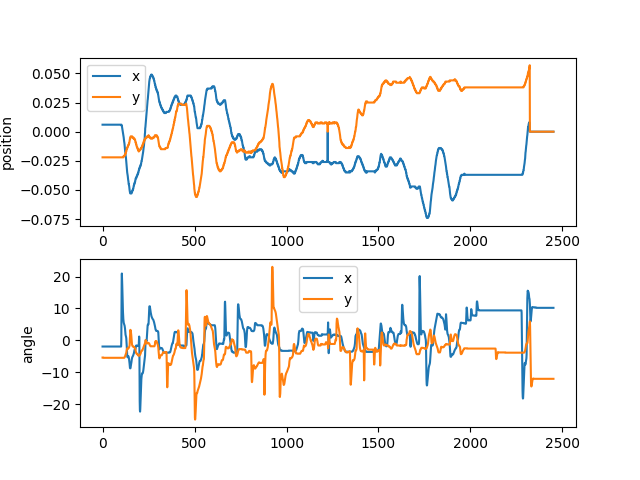

<IPython.core.display.Javascript object>


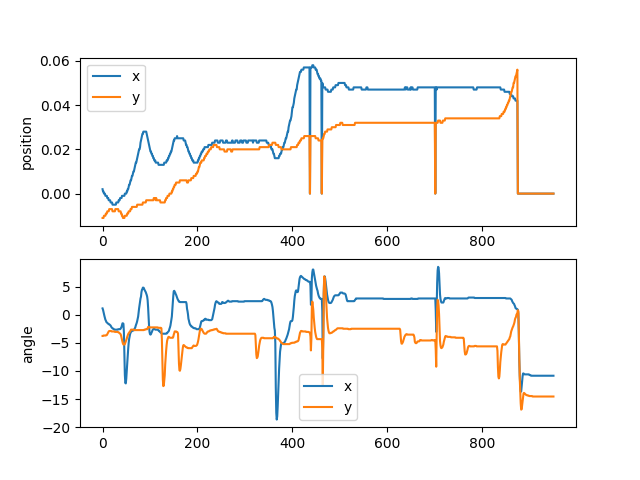

<IPython.core.display.Javascript object>


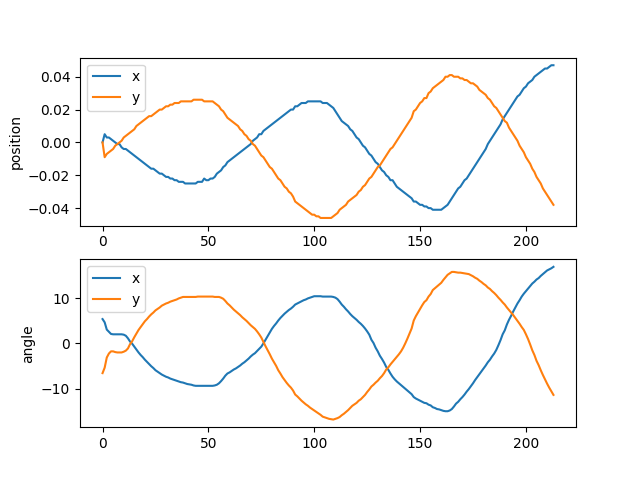

<IPython.core.display.Javascript object>


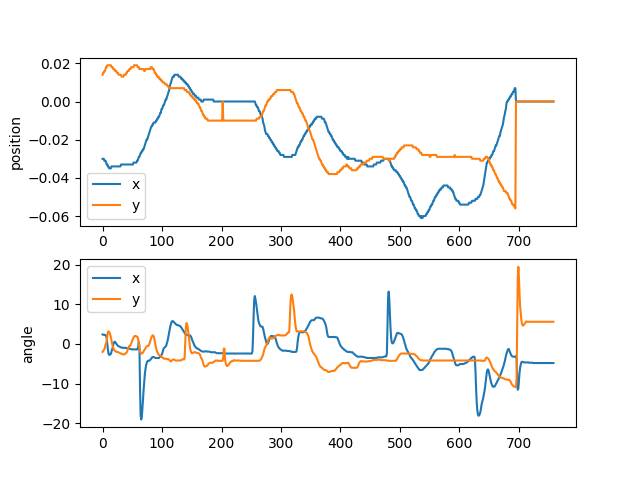

<IPython.core.display.Javascript object>


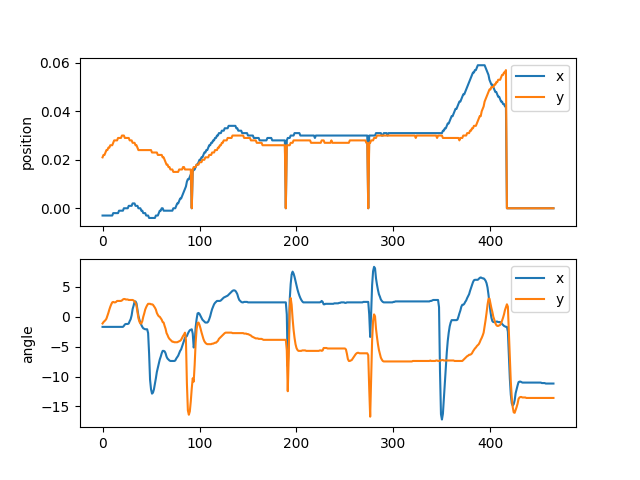

<IPython.core.display.Javascript object>


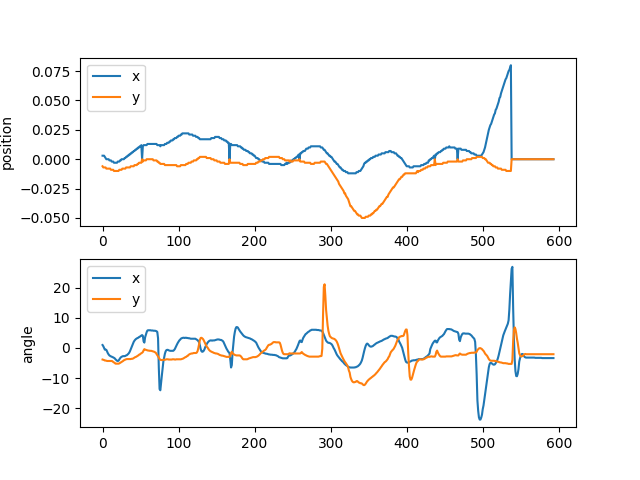

<IPython.core.display.Javascript object>


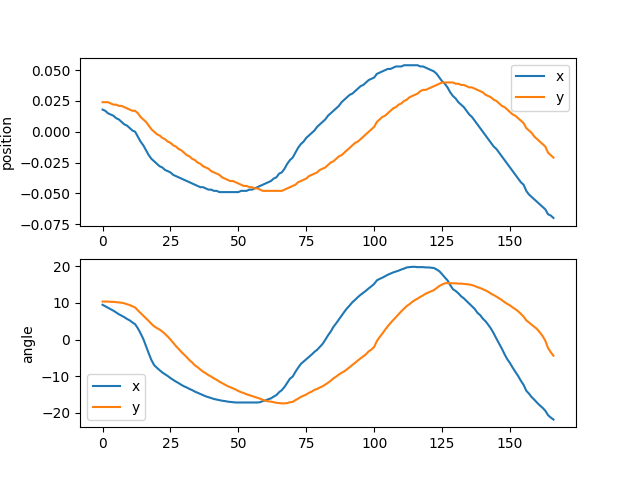

<IPython.core.display.Javascript object>


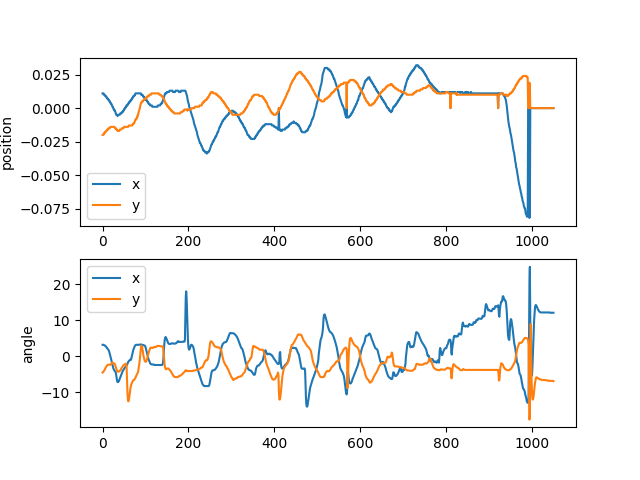

<IPython.core.display.Javascript object>


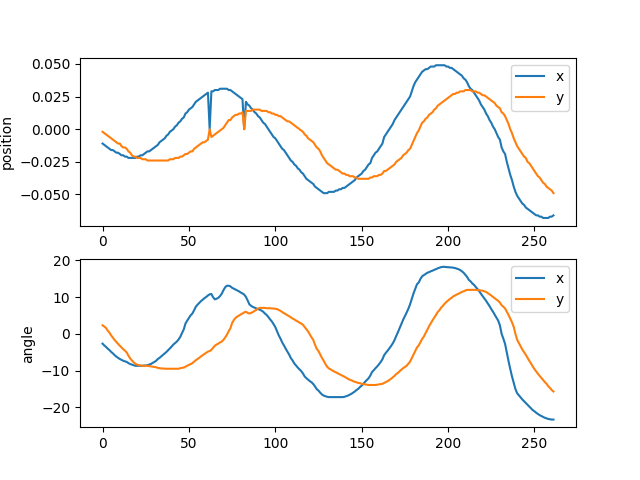

<IPython.core.display.Javascript object>


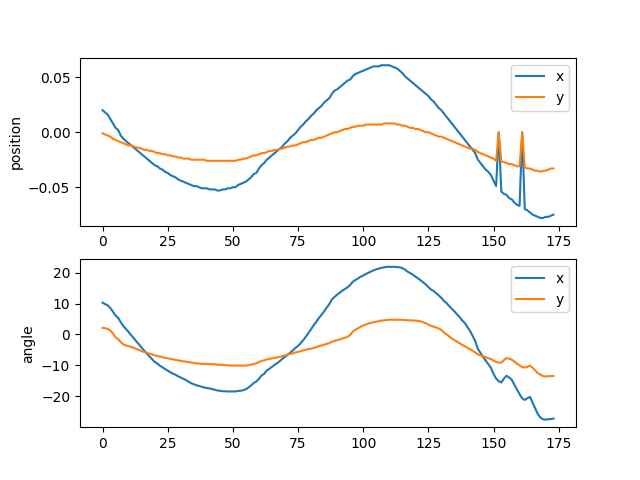

<IPython.core.display.Javascript object>


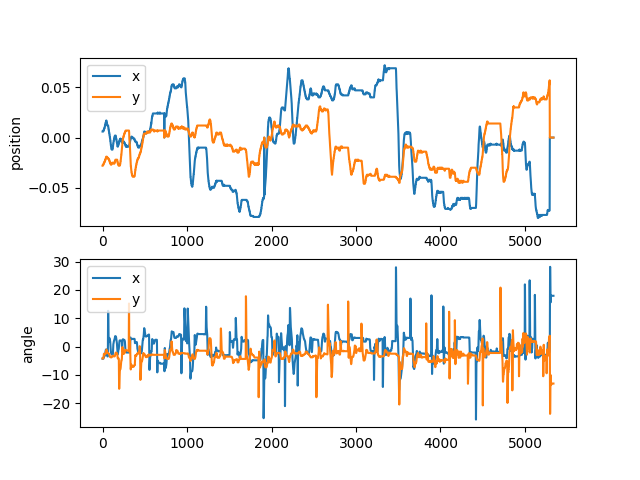

<IPython.core.display.Javascript object>


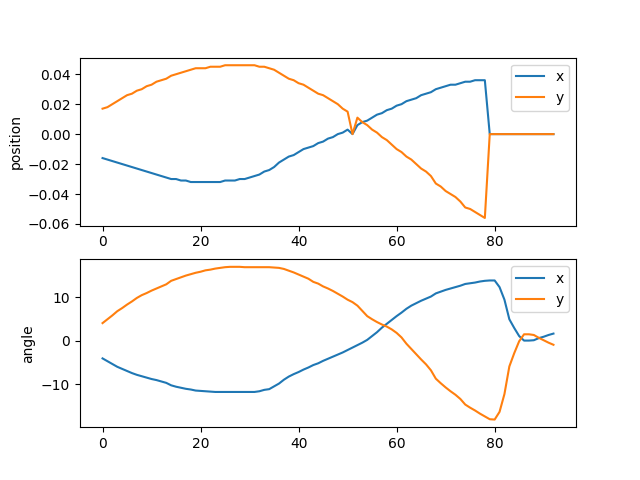

<IPython.core.display.Javascript object>


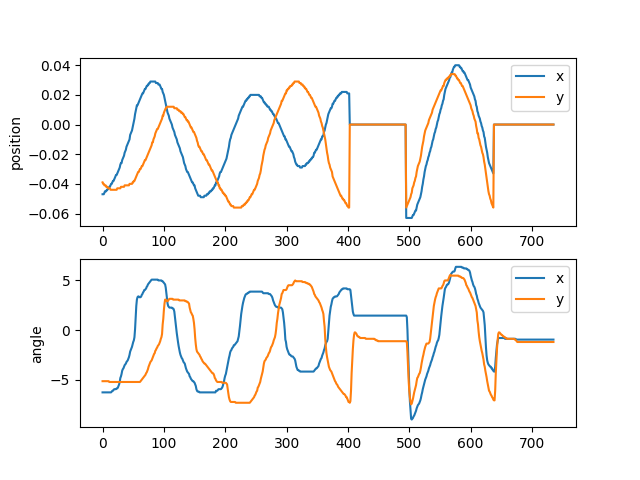

In [5]:
for data in datas:
    fig, axs = plt.subplots(2, 1)

    axs[0].plot(data['x'], label='x')
    axs[0].plot(data['y'], label='y')
    axs[0].set_ylabel('position')
    axs[0].legend()

    axs[1].plot(data['angle_x'], label='x')
    axs[1].plot(data['angle_y'], label='y')
    axs[1].set_ylabel('angle')
    axs[1].legend()

    plt.show()

It is possible to see that at some moments, the ball was undetected. Either for a one timestep, either for the whole end.

Regressions are very sensitive to outliers, thus it is very important to remove those errors

In [6]:
for data in datas:
    data.drop(data.loc[data['x']==0].index, inplace=True)
for data in test_datas:
    data.drop(data.loc[data['x']==0].index, inplace=True)
    
datas[-1] = datas[-1].iloc[:380, :]

<IPython.core.display.Javascript object>


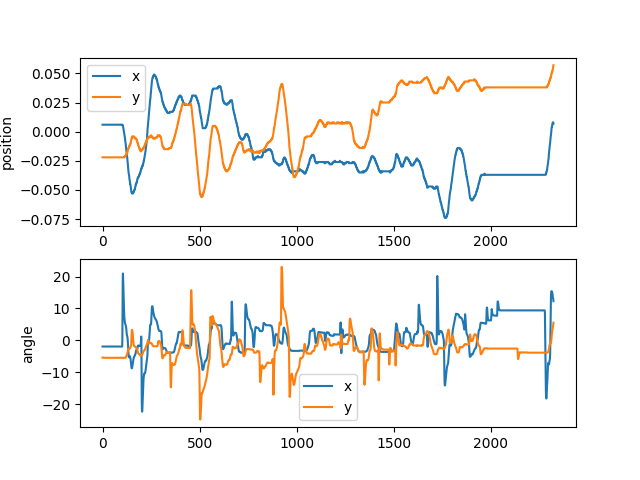

<IPython.core.display.Javascript object>


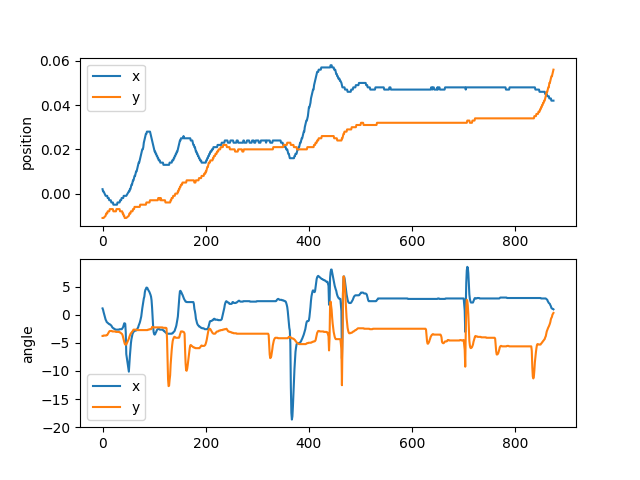

<IPython.core.display.Javascript object>


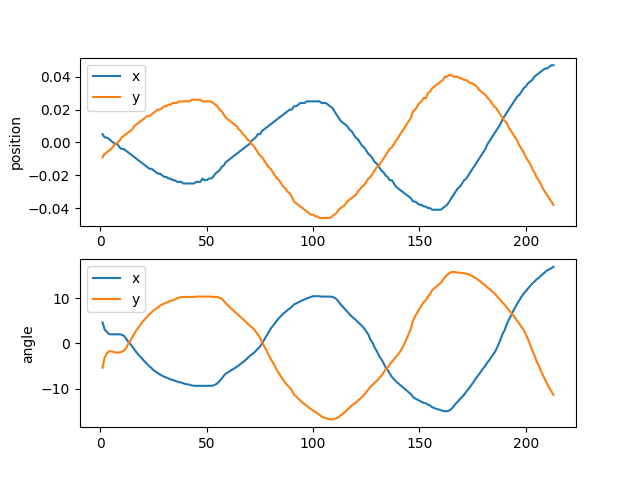

<IPython.core.display.Javascript object>


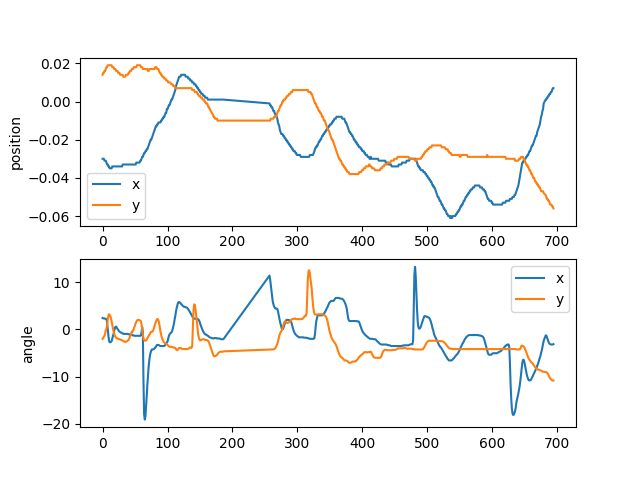

<IPython.core.display.Javascript object>


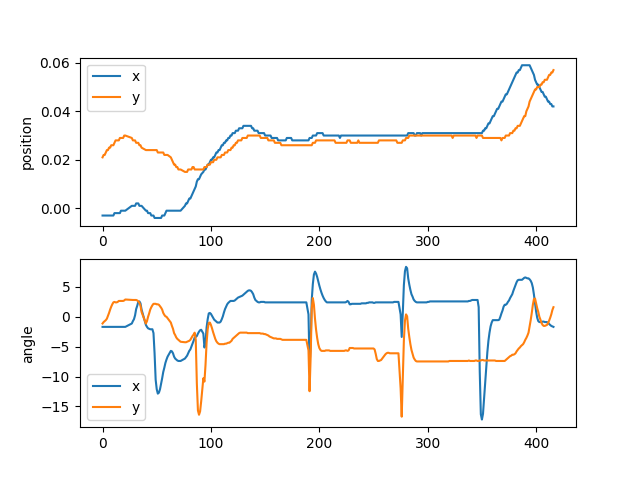

<IPython.core.display.Javascript object>


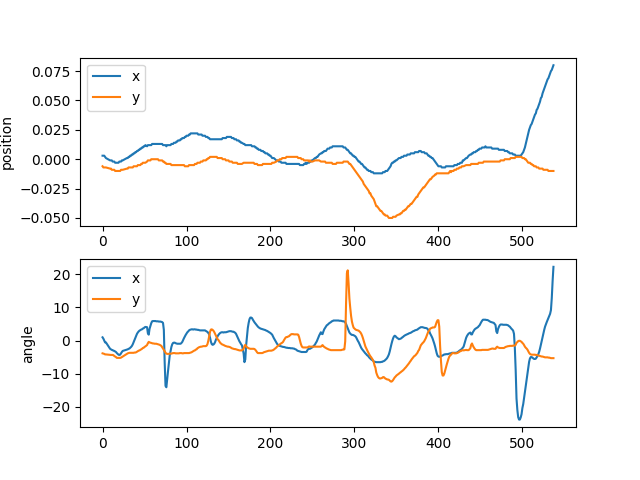

<IPython.core.display.Javascript object>


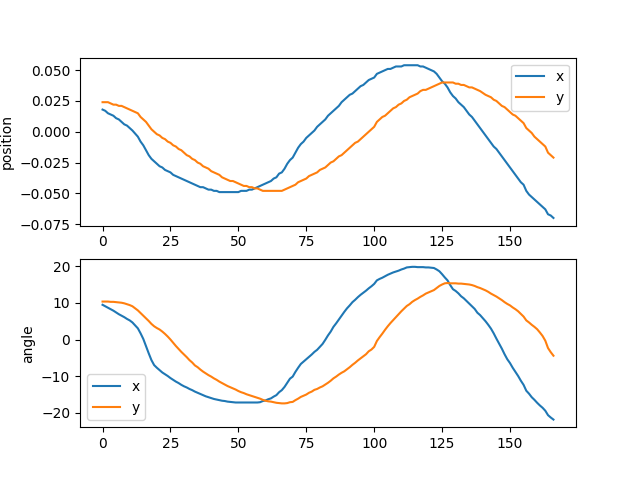

/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


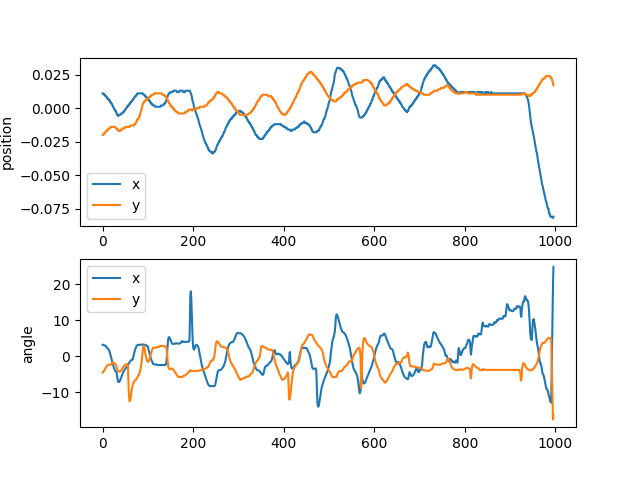

<IPython.core.display.Javascript object>


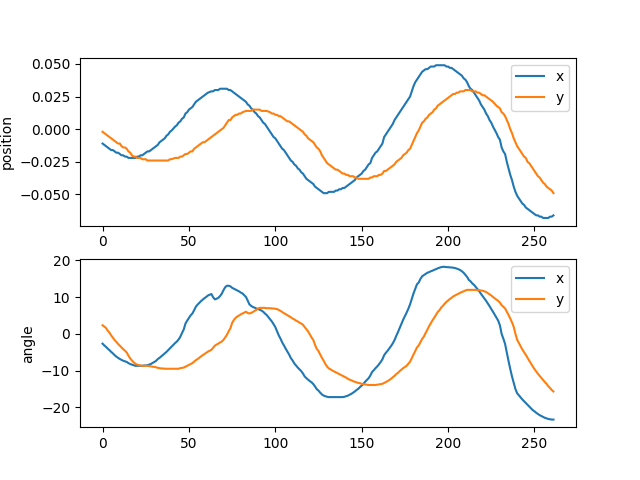

<IPython.core.display.Javascript object>


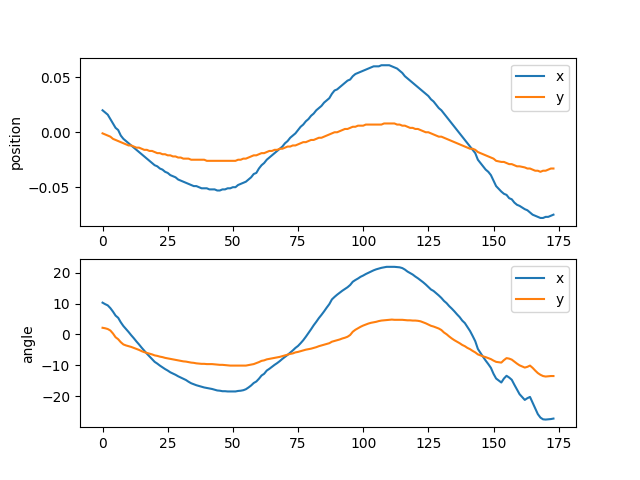

<IPython.core.display.Javascript object>


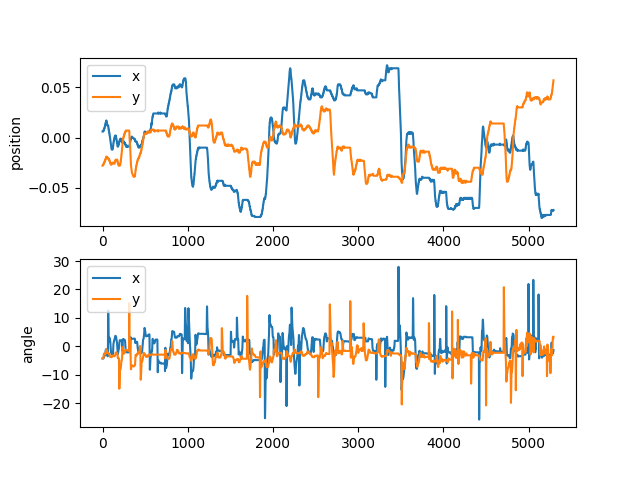

<IPython.core.display.Javascript object>


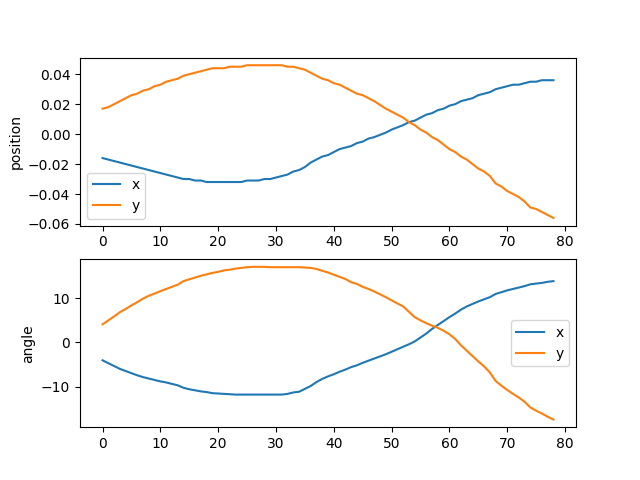

<IPython.core.display.Javascript object>


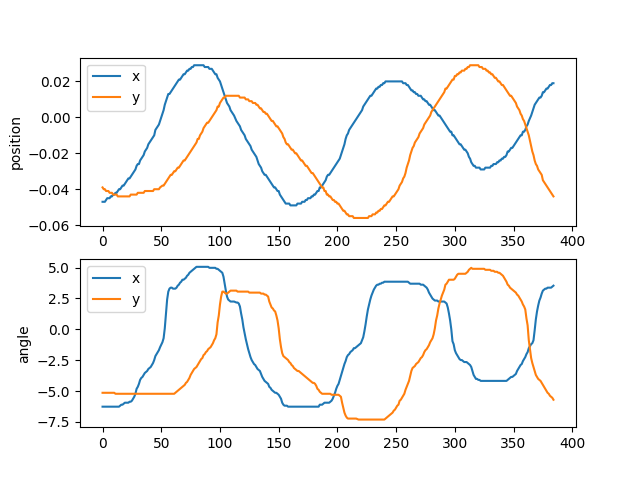

In [7]:
for data in datas:
    fig, axs = plt.subplots(2, 1)

    axs[0].plot(data['x'], label='x')
    axs[0].plot(data['y'], label='y')
    axs[0].set_ylabel('position')
    axs[0].legend()

    axs[1].plot(data['angle_x'], label='x')
    axs[1].plot(data['angle_y'], label='y')
    axs[1].set_ylabel('angle')
    axs[1].legend()

    plt.show()

/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


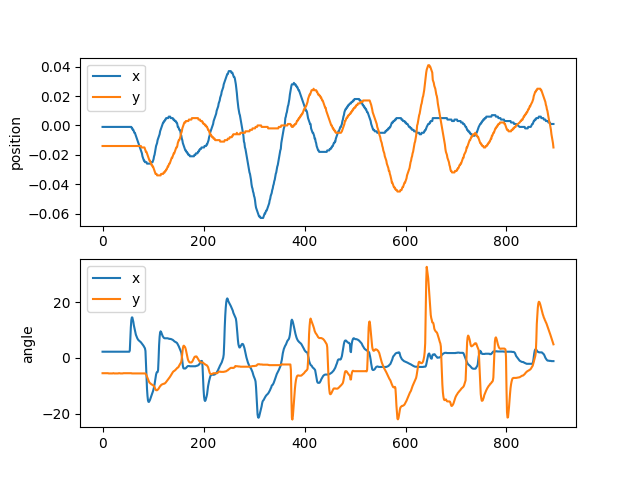

<IPython.core.display.Javascript object>


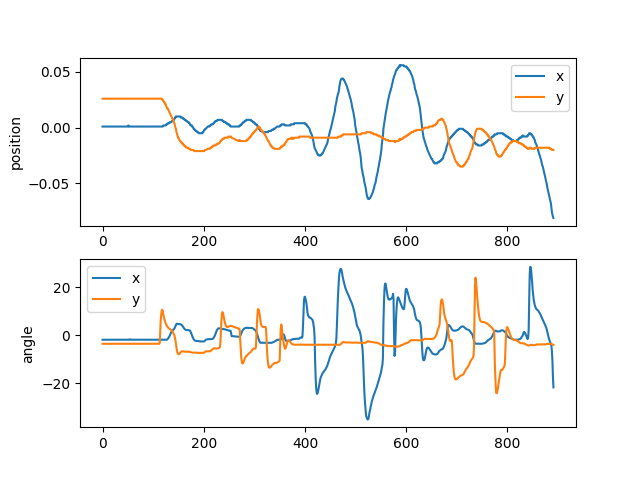

<IPython.core.display.Javascript object>


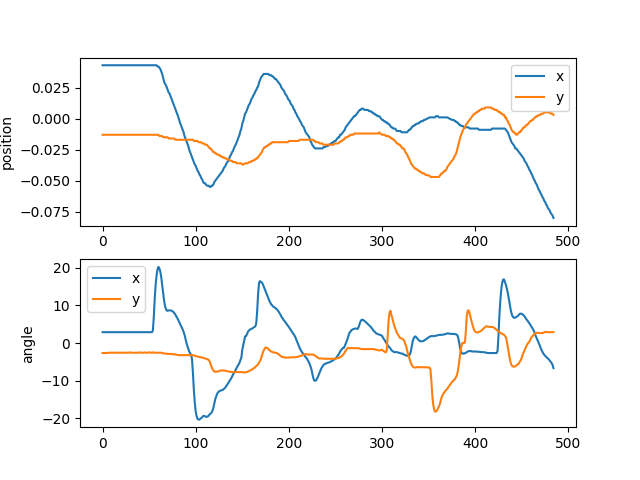

<IPython.core.display.Javascript object>


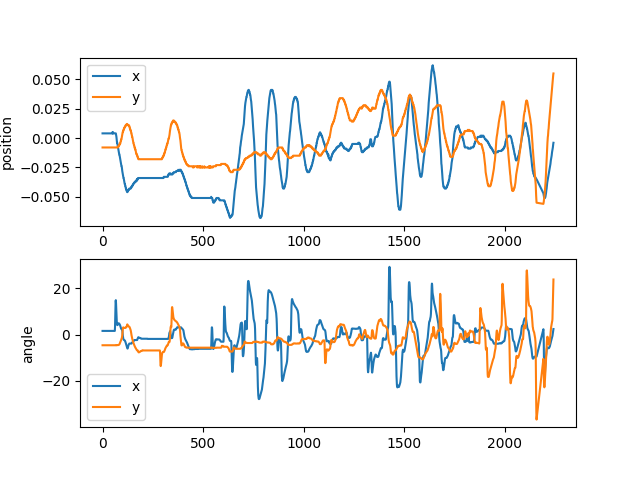

In [8]:
for data in test_datas:
    fig, axs = plt.subplots(2, 1)

    axs[0].plot(data['x'], label='x')
    axs[0].plot(data['y'], label='y')
    axs[0].set_ylabel('position')
    axs[0].legend()

    axs[1].plot(data['angle_x'], label='x')
    axs[1].plot(data['angle_y'], label='y')
    axs[1].set_ylabel('angle')
    axs[1].legend()

    plt.show()

Since all datasets are cleaned. It is now possible to compute the speed and concaten them.

In [9]:
for data in datas:
    data['d_x'] = (data['x'] - data['x'].shift(1)) / DT
    data['d_y'] = (data['y'] - data['y'].shift(1)) / DT
    data['target_x'] = data['d_x'].shift(-1)
    data['target_y'] = data['d_y'].shift(-1)
    data.dropna(inplace=True)
for data in test_datas:
    data['d_x'] = (data['x'] - data['x'].shift(1)) / DT
    data['d_y'] = (data['y'] - data['y'].shift(1)) / DT
    data['target_x'] = data['d_x'].shift(-1)
    data['target_y'] = data['d_y'].shift(-1)
    data.dropna(inplace=True)
    
data = datas[0]
for df in datas[0:]:
    data = pd.concat([data, df])
print(data.head())

       x      y  angle_x  angle_y  input_x  input_y  d_x  d_y  target_x  \
1  0.006 -0.022   -1.929   -5.384   -0.229   -0.169  0.0  0.0       0.0   
2  0.006 -0.022   -1.929   -5.384   -0.255   -0.164  0.0  0.0       0.0   
3  0.006 -0.022   -1.929   -5.384   -0.227   -0.176  0.0  0.0       0.0   
4  0.006 -0.022   -1.929   -5.384   -0.191   -0.187  0.0  0.0       0.0   
5  0.006 -0.022   -1.929   -5.464   -0.191   -0.207  0.0  0.0       0.0   

   target_y  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
5       0.0  


# Neural network training
Since the ball behavior isn't linear, multiples NN are created and trained to model the system.

The inputs and targets are converted into pytorch format

## Scaling

In [10]:
max(- data['x'].min(), data['x'].max())

0.08199999999999999

In [11]:
max(- data['y'].min(), data['y'].max())

0.055999999999999994

In [12]:
max(- data['d_x'].min(), data['d_x'].max(), - data['d_y'].min(), data['d_y'].max())

4.5

In [13]:
data['d_x'].std()

0.4057012818600118

In [14]:
data['d_x'].abs().mean()

0.2158581188323787

## Inputs

- x * 15
- y * 20
- d_x / 6
- d_y / 6
- angle_x / 20
- angle_y / 20

## Output
- d_x
- d_y

In [15]:
x_np = data[['x', 'y', 'd_x', 'd_y', 'angle_x', 'angle_y']].to_numpy()

x_np[:, 0] = x_np[:, 0] * 15.
x_np[:, 1] = x_np[:, 1] * 20.
x_np[:, 2] = x_np[:, 2] * 6.
x_np[:, 3] = x_np[:, 3] * 6.
x_np[:, 4] = x_np[:, 4] / 25.
x_np[:, 5] = x_np[:, 5] / 25.

x = Variable(
    torch.from_numpy(
        x_np[:, 2:]
    ).type(torch.FloatTensor)
)

y = Variable(
    torch.from_numpy(data[['target_x', 'target_y']].to_numpy()).type(torch.FloatTensor)
)

In [16]:
nets = [BallNet1Hidden(6, 16, 2), BallNet1Hidden(6, 32, 2), BallNet1Hidden(6, 64, 2), 
        BallNet1Hidden(6, 128, 2), BallNet2Hidden(6, 16, 16, 2), BallNet2Hidden(6, 32, 16, 2),
        BallNet2Hidden(6, 64, 32, 2), BallNet2Hidden(6, 128, 64, 2), BallNet2Hidden(6, 128, 128, 2)]
nets = [BallNet2Hidden(4, 128, 64, 2)]

In [17]:
print(x)
print(y)

tensor([[ 0.0000,  0.0000, -0.0772, -0.2154],
        [ 0.0000,  0.0000, -0.0772, -0.2154],
        [ 0.0000,  0.0000, -0.0772, -0.2154],
        ...,
        [ 3.0000, -3.0000,  0.1350, -0.2154],
        [ 0.0000, -3.0000,  0.1350, -0.2186],
        [ 3.0000, -3.0000,  0.1382, -0.2218]])
tensor([[ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        ...,
        [ 0.0000, -0.5000],
        [ 0.5000, -0.5000],
        [ 0.0000, -0.5000]])


In [18]:
nets = [train_ball_model(net, x, y, n_epoch=2000) for net in nets]

tensor(0.0977, grad_fn=<MseLossBackward>) -0.8675279078525358


In [19]:
test = test_datas[1][['x', 'y', 'd_x', 'd_y', 'angle_x', 'angle_y']].to_numpy()
pos = nets[0].recurcive_predict(test[0, 0], test[0, 1], test[0, 2], test[0, 3], test[:, 4:])

-0.010227352380752563 0.053683094680309296
-0.12717439234256744 0.010518335737287998
-0.06572525203227997 -0.0004696575924754143
-0.06336048245429993 0.05399538204073906
-0.1620127558708191 -0.012874091975390911
-0.007227972149848938 -0.0003844359889626503
-0.017400294542312622 0.05827253311872482
-0.13625872135162354 0.012956609018146992
-0.06391328573226929 -0.008606071583926678
-0.044496819376945496 0.07058671116828918
-0.18494582176208496 -0.0023068031296133995
-0.03612595796585083 -0.015688199549913406
-0.019679412245750427 0.08385360985994339
-0.18058960139751434 0.023245137184858322
-0.07353964447975159 -0.02633296325802803
-0.0011558085680007935 0.09404341131448746
-0.19186274707317352 0.043347276747226715
-0.10546155273914337 -0.054436974227428436
0.08123385161161423 0.10044924169778824
-0.21688887476921082 -0.01687859743833542
-0.03455476462841034 -0.04784524440765381
0.07963590323925018 0.11175581812858582
-0.2341618537902832 -0.020814213901758194
-0.042773857712745667 -0.06

0.38232868909835815 -0.2197592556476593
0.38249891996383667 -0.21703331172466278
0.38213586807250977 -0.21679413318634033
0.3810197710990906 -0.21888482570648193
0.3797121047973633 -0.22231653332710266
0.3784552812576294 -0.22615867853164673
0.3768497407436371 -0.23086099326610565
0.3759995698928833 -0.23437464237213135
0.37473905086517334 -0.2384268343448639
0.3743588924407959 -0.24103720486164093
0.3725193738937378 -0.24239501357078552
0.3717990815639496 -0.24275320768356323
0.3711729347705841 -0.2433408498764038
0.37075376510620117 -0.24395623803138733
0.3704912066459656 -0.2438564896583557
0.37054795026779175 -0.24380463361740112
0.37008136510849 -0.24455198645591736
0.3697606921195984 -0.24443992972373962
0.36982545256614685 -0.24437610805034637
0.3698517084121704 -0.24439075589179993
0.3698439300060272 -0.2443958818912506
0.369841992855072 -0.24439403414726257
0.3698429465293884 -0.24439364671707153
0.36935529112815857 -0.24512863159179688
0.3671051263809204 -0.24811537563800812


0.3072355389595032 -0.34667351841926575
0.28852567076683044 -0.2823874056339264
0.28350383043289185 -0.27106383442878723
0.2899898886680603 -0.26429611444473267
0.30292126536369324 -0.27612683176994324
0.3032546937465668 -0.2812163531780243
0.3018164038658142 -0.2700576186180115
0.31220099329948425 -0.2721634805202484
0.318348228931427 -0.27829885482788086
0.319452166557312 -0.2770870327949524
0.3234627842903137 -0.27157729864120483
0.3307868540287018 -0.26856154203414917
0.33767837285995483 -0.2625894546508789
0.34782707691192627 -0.2585679292678833
0.35600876808166504 -0.2547294497489929
0.3620883822441101 -0.24963194131851196
0.3676847219467163 -0.2419959306716919
0.37517622113227844 -0.2357916235923767
0.3785663843154907 -0.2306530475616455
0.37922215461730957 -0.22600619494915009
0.3811820447444916 -0.21947313845157623
0.3827032148838043 -0.2142333686351776
0.39151811599731445 -0.19631165266036987
0.3920881748199463 -0.16571277379989624


In [20]:
print(pos)

[[ 0.001       0.026     ]
 [ 0.00097955  0.02610737]
 [ 0.0007252   0.0261284 ]
 ...
 [ 0.32120167 -0.32907343]
 [ 0.32198471 -0.32946605]
 [ 0.32276889 -0.32979748]]


/home/benoit/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


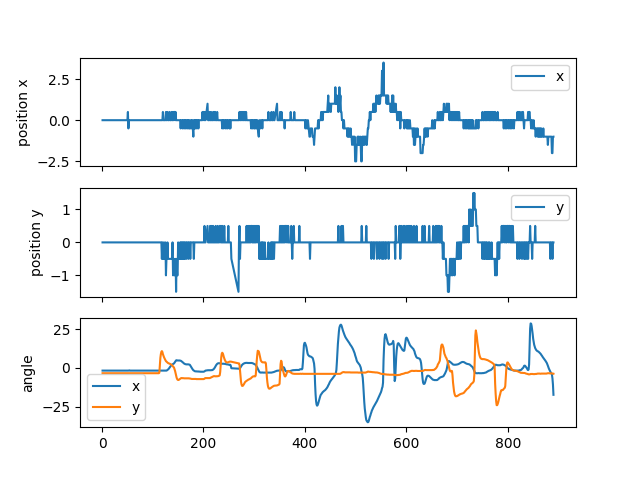

In [22]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(test_datas[1]['d_x'], label='x')
#axs[0].plot(pos[:, 0], label='x nn')
axs[0].set_ylabel('position x')
axs[0].legend()

axs[1].plot(test_datas[1]['d_y'], label='y')
#axs[1].plot(pos[:, 1], label='y nn')
axs[1].set_ylabel('position y')
axs[1].legend()

axs[2].plot(test_datas[1]['angle_x'], label='x')
axs[2].plot(test_datas[1]['angle_y'], label='y')
axs[2].set_ylabel('angle')
axs[2].legend()

plt.show()